# NSVM

In [ ]:
!git clone https://github.com/KotikNikita/HierarchicalNeuralFinancialForecasting.git

Cloning into 'HierarchicalNeuralFinancialForecasting'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 64 (delta 0), reused 1 (delta 0), pack-reused 60
Unpacking objects: 100% (64/64), done.


### Model definition

In [ ]:
import torch
import torch.nn as nn

class InfNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.mlp_z_mean = nn.Linear(hidden_dim, latent_dim)
        self.mlp_z_logvar = nn.Linear(hidden_dim, latent_dim)

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h0 = torch.zeros(1, batch_size, self.hidden_dim)
        c0 = torch.zeros(1, batch_size, self.hidden_dim)

        out, _ = self.rnn(x, (h0, c0))

        out = out.reshape(-1, self.hidden_dim)

        logvar_z = self.mlp_z_logvar(out)
        mean_z = self.mlp_z_mean(out)

        mean_z

        noise = torch.randn(batch_size*seq_len, self.latent_dim)
        z = noise * torch.exp(logvar_z) + mean_z
        z = z.reshape(batch_size, seq_len, self.latent_dim)
        mean_z = mean_z.reshape(batch_size, seq_len, self.latent_dim)
        logvar_z = logvar_z.reshape(batch_size, seq_len, self.latent_dim)

        return z, mean_z, logvar_z


class GenNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.rnn = nn.LSTM(input_dim + latent_dim, hidden_dim, batch_first=True)
        self.mlp_x_mean = nn.Linear(hidden_dim, input_dim)
        self.mlp_x_logvar = nn.Linear(hidden_dim, input_dim)

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
    
    def forward(self, x, z):
        batch_size, seq_len, _ = x.shape
        h0 = torch.zeros(1, batch_size, self.hidden_dim)
        c0 = torch.zeros(1, batch_size, self.hidden_dim)

        out, _ = self.rnn(torch.cat([x,z], dim=-1), (h0, c0))

        out = out.reshape(-1, self.hidden_dim)
        logvar_x = self.mlp_x_logvar(out)
        mean_x = self.mlp_x_mean(out)

        noise = torch.randn(batch_size * seq_len, self.input_dim)
        x = noise * torch.exp(logvar_x) + mean_x
        x = x.reshape(batch_size, seq_len, self.input_dim)
        mean_x = mean_x.reshape(batch_size, seq_len, self.input_dim)
        logvar_x = logvar_x.reshape(batch_size, seq_len, self.input_dim)

        return x, mean_x, logvar_x

In [ ]:
class NSVM(nn.Module):
    def __init__(self, inf_model, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.gen = GenNet(input_dim, hidden_dim, latent_dim)
        self.inf = inf_model(input_dim, hidden_dim, latent_dim)
        self.beta = 0.0

    def forward(self, x, noise=True):
        z, mu_z, logvar_z = self.inf(x)
        if noise == False:
            z = mu_z
        x, mu_x, logvar_x = self.gen(x, z)
        return mu_x, logvar_x, mu_z, logvar_z

    def loss(self, x, y):
        mu_x, logvar_x, mu_z, logvar_z = self(x)
        logvar_x *= 0 
        # recon_loss = torch.mean((mu_x[:, :-1] - y) ** 2 / 2 / torch.exp(2 * logvar_x[:, :-1]) + logvar_x[:, :-1])
        recon_loss = F.l1_loss(mu_x[:, :-1], y)
        kld_loss = -0.5 * torch.mean(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())
        loss = recon_loss + self.beta * kld_loss
        return loss

    def predict(self, x, noise=True):
        with torch.no_grad():
            y_hat = self(x, noise)
        return y_hat

In [ ]:
class InfNetTrue(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.mlp_z_mean = nn.Linear(hidden_dim, latent_dim)
        self.mlp_z_logvar = nn.Linear(hidden_dim, latent_dim)
        self.rnn_z = nn.RNNCell(hidden_dim + latent_dim, hidden_dim)

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h0 = torch.zeros(1, batch_size, self.hidden_dim)
        out, _ = self.rnn(x, h0)
        out = out.reshape(batch_size, -1,  self.hidden_dim)

        h_z = torch.zeros(batch_size, self.hidden_dim)
        noise = torch.randn(batch_size, seq_len, self.latent_dim)
        z = [torch.zeros(batch_size, self.latent_dim)]
        mu_zs = []
        logvar_zs = []

        for i in range(seq_len):
            input_rnn = torch.cat([out[:,i], z[-1]], dim=1)
            h_z = self.rnn_z(input_rnn, h_z)
            mu_z = self.mlp_z_mean(h_z)
            logvar_z = self.mlp_z_logvar(h_z)
            z_new = noise[:, i] * torch.exp(logvar_z) + mu_z
            z.append(z_new)
            mu_zs.append(mu_z)
            logvar_zs.append(mu_z)

        z = torch.stack(z[:-1], dim=1)
        mu_z = torch.stack(mu_zs, dim=1)
        logvar_z = torch.stack(logvar_zs, dim=1)
        return z, mu_z, logvar_z

### Loading and preprocessing data

In [ ]:
import pandas as pd
import numpy as np
import tqdm
import torch

from matplotlib import pyplot as plt

In [ ]:
df = pd.read_csv('/content/HierarchicalNeuralFinancialForecasting/data/second_df_with_RM_30_5_H2.csv')

In [ ]:
df['log_returns'] = np.log(df.close/df.close.shift(1))
df.dropna(inplace=True)

In [ ]:
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [ ]:
intervals = [12, 84]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = np.nan_to_num(vols, 0)

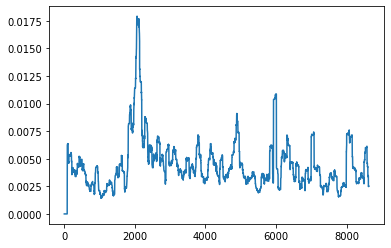

In [ ]:
plt.plot(vols_df[84])

In [ ]:
# X_t = torch.cat([torch.tensor(df.log_returns.values).unsqueeze(-1), torch.tensor(np.stack(list(vols_df.values())))])
X_t = torch.tensor(vols_df[84]).unsqueeze(-1)

In [ ]:
model = NSVM(InfNet, 1, 10, 4)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
X_tensor = X_t.unsqueeze(0).float()
y = torch.clone(X_tensor[:, 1:])

In [ ]:
# import torch.nn.functional as F
# res = model(X_tensor)[1]
# tmp = torch.exp(2 * res)
# (F.conv1d(tmp[:, 0:1].view(1, 1, -1), torch.ones(12).view(1, 1, -1)) / 12) - tmp[11:, 1]

### Training

In [ ]:
from torch.nn.utils import clip_grad_norm_

In [ ]:
losses = []

for _ in tqdm.trange(200):
    opt.zero_grad()
    loss = model.loss(X_tensor, y)
    loss.backward()
    clip_grad_norm_(model.parameters(), 4.0)
    losses.append(loss.item())

    opt.step()

100%|██████████| 200/200 [09:28<00:00,  2.84s/it]


In [ ]:
with torch.no_grad():
    mu_x, logvar_x, mu_z, _ = model(X_tensor, noise=False)

In [ ]:
import matplotlib

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

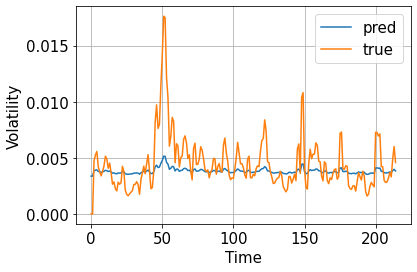

In [ ]:
plt.figure()
plt.plot((mu_x[0, 30::40, 0]) , label='pred')
plt.plot(y[0, 29::40, 0], label='true')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.grid()
plt.legend()
plt.savefig('volatiliy_pred')
plt.show()

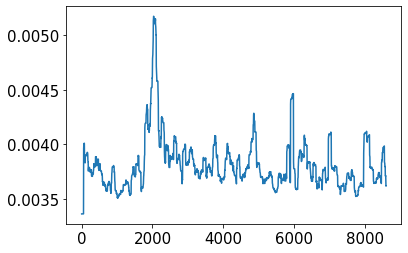

In [ ]:
plt.plot((mu_x[0, 30:, 0]), label='pred')

In [ ]:
with open('weekly_vol.npy', 'wb') as f:
    np.save(f, mu_x[0, 30::40, 0])

In [ ]:
!pip install arch

  Using cached arch-5.1.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (902 kB)
  Using cached property_cached-1.6.4-py2.py3-none-any.whl (7.8 kB)
  Using cached statsmodels-0.13.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


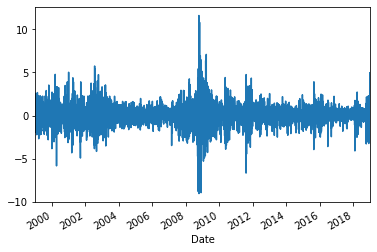

In [ ]:
import datetime as dt

import arch.data.sp500

st = dt.datetime(1988, 1, 1)
en = dt.datetime(2018, 1, 1)
data = arch.data.sp500.load()
market = data["Adj Close"]
data['log_returns'] = np.log(data["Adj Close"]/data["Adj Close"].shift(1))
data.dropna(inplace=True)
returns = 100 * market.pct_change().dropna()
ax = returns.plot()
xlim = ax.set_xlim(returns.index.min(), returns.index.max())

In [ ]:
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

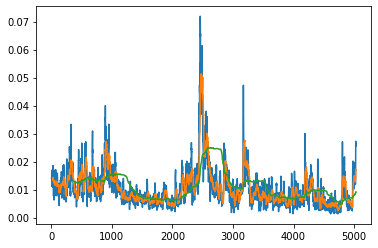

In [ ]:
plt.plot(vols_df[7])
plt.plot(vols_df[30])
plt.plot(vols_df[365])
plt.show()

In [ ]:
from arch import arch_model

am = arch_model(returns)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6942.1595030183935
Iteration:     10,   Func. Count:     72,   Neg. LLF: 6936.718529849331
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6936.718476988906
            Iterations: 11
            Function evaluations: 79
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Thu, Dec 23 2021   Df Residuals:                     5029
Time:        

In [ ]:
# X = df.close.values
# X = np.log(X[1:] / X[:-1])
# X = np.expand_dims(X, -1)
# X = np.expand_dims(X, 0)

In [ ]:
# EMBED_DIM = 10
# xbat = X.shape[0]
# xlen = X.shape[1]
# xwid = X.shape[2]
# newlen = xlen - EMBED_DIM + 1
# newwid = xwid * EMBED_DIM

In [ ]:
# Xs = torch.zeros((xbat, newlen, newwid))
# #print X_test_raw.shape
# for i in range(EMBED_DIM):
#     Xs[:, :, i*xwid:(i+1)*xwid] = torch.tensor(X[:, i:i+newlen, :])

In [ ]:
# X_train, X_test = Xs[:8000], Xs[8000:]
# X_train_t = torch.tensor(X_train)
# X_test_t = torch.tensor(X_test)